In [1]:
import re
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.stem import SnowballStemmer
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
random.seed(10)
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [2]:

df = pd.read_table('C:\\Users\\Keerthi\\Desktop\\Jigsaw\\FIVERR\\SMSSpamCollection', sep="\t", names=['label', 'SMS'])

In [6]:
df.head()

,label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
spam_sms = df[df["label"] == "spam"]["SMS"]
ham_sms = df[df["label"] == "ham"]["SMS"]

spam_words = []
ham_words = []

def SpamWords(spamwords):
    global spam_words
    words = [word.lower() for word in word_tokenize(spamwords) if word.lower() not in stopwords.words("english") ]
    spam_words = spam_words + words
    
def HamWords(hamwords):
    global ham_words
    words = [word.lower() for word in word_tokenize(hamwords) if word.lower() not in stopwords.words("english") ]
    ham_words = ham_words + words

spam_word=spam_sms.apply(SpamWords)
ham_word=ham_sms.apply(HamWords)

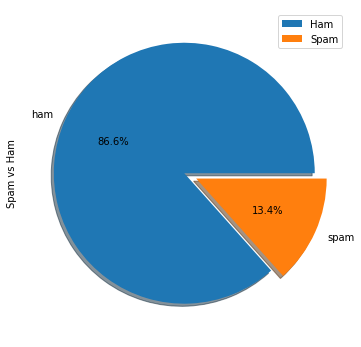

In [7]:
df["label"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

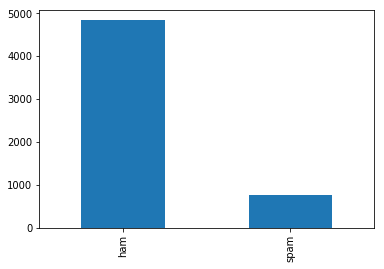

In [5]:
df["label"].value_counts().plot(kind = 'bar')

plt.show()

In [6]:
df['label']=df['label'].map(lambda x: 1 if x=='spam' else 0)

In [7]:
#data cleaning
stemmer = SnowballStemmer("english")
def cleaning(sms):  
    sms = sms.translate(str.maketrans('', '', string.punctuation))
    sms_clean = [stemmer.stem(text) for text in sms.split() if text.lower() not in stopwords.words("english")]
    return " ".join(sms_clean)


In [8]:
df['Cleaned_SMS'] = df.SMS.apply(cleaning).str.strip().str.split('[\W_]+')

In [9]:
def convert_toList(lines):
    dataset = list(lines)
    for i in range(1,len(dataset)):
        dataset[i] = [(x) for x in dataset[i]]
    return dataset

In [10]:
Data=convert_toList(df['Cleaned_SMS'])

In [11]:
 def calc_TF(data):
    #Counts the freq of the word  in message
    TFDict = {}
    for word in data:
        if word in TFDict:
            TFDict[word] += 1
        else:
            TFDict[word] = 1
    for word in TFDict:
        TFDict[word] = TFDict[word] / len(data)
    return TFDict
#Computes tf for each word
tfDict=[]
for i in range(0,len(Data)):
    TF=(calc_TF(Data[i]))
    tfDict.append(TF)

In [12]:
def calc_count(tfDict): 
    countDict = {}
    for data in tfDict:
        for word in data:
            if word in countDict:
                countDict[word] += 1
            else:
                countDict[word] = 1
    return countDict

  #calculate the count of words in message
countDict = calc_count(tfDict)

In [13]:
def calc_IDF(countDict):
    idfDict = {}
    for word in countDict:
        idfDict[word] = math.log(len(Data) / countDict[word])
    return idfDict
  #calculate the idf for word
idfDict = calc_IDF(countDict)

In [14]:
def calc_TFIDF(reviewTFDict):
    reviewTFIDFDict = {}
    #For each word we multiply its tf and its idf.
    for word in reviewTFDict:
        reviewTFIDFDict[word] = reviewTFDict[word] * idfDict[word]
    return reviewTFIDFDict
tfidfDict = [calc_TFIDF(data) for data in tfDict]

In [15]:
wordDict = sorted(countDict.keys())

def TFIDFVector(review):
    tfidfVector = [0.0] * len(wordDict)
    for i, word in enumerate(wordDict):
          if word in review:
            tfidfVector[i] = review[word]
    return tfidfVector

tfidfVector = [TFIDFVector(data) for data in tfidfDict]

In [16]:
X=pd.DataFrame(tfidfVector).as_matrix()
y=df['label']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y.astype(int), test_size=.20,random_state=201)

In [18]:
y_train=y_train.to_numpy()
y_test=y_test.to_numpy()

In [19]:
class NaiveBayes(object):
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def fit(self, X, y,alpha):
        self.alpha =alpha
        length = X.shape[0]
        category = [[x for x, t in zip(X, y) if t == c] for c in np.unique(y)]
        self.category_log_calc = [np.log(len(i) / length) for i in category]
        total = np.array([np.array(i).sum(axis=0) for i in category]) + self.alpha
        self.calc_log_prob = np.log(total / total.sum(axis=1)[np.newaxis].T)
        return self

    def predict_log_proba(self, X):
        return [(self.calc_log_prob * x).sum(axis=1) + self.category_log_calc for x in X]

    def predict(self, X):
        return np.argmax(self.predict_log_proba(X), axis=1)
  

In [20]:
nb = NaiveBayes().fit(X_train, y_train,alpha=1.0)


In [21]:
y_predict_prob_train=(nb.predict_log_proba(X_train))
y_predict_train=(nb.predict(X_train))


In [22]:
y_predict_prob=(nb.predict_log_proba(X_test))
y_predict=(nb.predict(X_test))

In [23]:
def getAccuracy(actual, predict):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predict[i]:
            correct += 1
    return (correct/float(len(actual))) 

In [24]:
print('Accuracy of Training data:', getAccuracy(y_train,y_predict_train))
print('Accuracy of Testing data:', getAccuracy(y_test,y_predict))

Accuracy of Training data: 0.9766659187794481
Accuracy of Testing data: 0.9542600896860987


In [25]:
def calc_confusion_mat(pred_arr, input_arr):
    conf_arr = [[0, 0], [0, 0]]
    for i in range(len(pred_arr)):
        if int(input_arr[i]) == 0:
            if float(pred_arr[i]) == 1:
                    conf_arr[0][1] = conf_arr[0][1] + 1
            else:
                    conf_arr[0][0] = conf_arr[0][0] + 1
        elif int(input_arr[i]) == 1:
            if float(pred_arr[i]) ==0:
                    conf_arr[1][0] = conf_arr[1][0] +1
            else:
                    conf_arr[1][1] = conf_arr[1][1] +1
    return np.array(conf_arr)



In [26]:
confusion_matrix=calc_confusion_mat(y_test, y_predict)


In [27]:
confusion_mat = pd.DataFrame(confusion_matrix, index=['Actually"not SPAM"','Actually "SPAM"'], columns=['Predicted "not SPAM"','Predicted "SPAM"'])

confusion_mat

,"Predicted ""not SPAM""","Predicted ""SPAM"""
"Actually""not SPAM""",971,51
"Actually ""SPAM""",0,93


In [28]:
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def f_score (precision,recall):
    return 2*precision*recall / (precision + recall)

def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

In [29]:
label=1
print("precision:" ,precision(label,confusion_matrix))
print("recall :", recall(label,confusion_matrix))
print('F-Score -->',f_score(precision(label,confusion_matrix),recall(label,confusion_matrix)))
print('Accuracy-->',accuracy(confusion_matrix))

precision: 0.6458333333333334
recall : 1.0
F-Score --> 0.7848101265822784
Accuracy--> 0.9542600896860987


#### Evaluating the performance of classifier for different values of alpha

In [30]:
def func_graph(acc,alpha,f1,title):
    fig = plt.figure()
    fig.suptitle(title)
    plt.xlabel('i')
    plt.ylabel('Performance Measure')
    plt.plot(alpha,acc, '-.', color="orange", label="Accuracy")
    plt.plot(alpha,f1, '-.', color="green", label="F Score")
    plt.legend(loc='lower left')

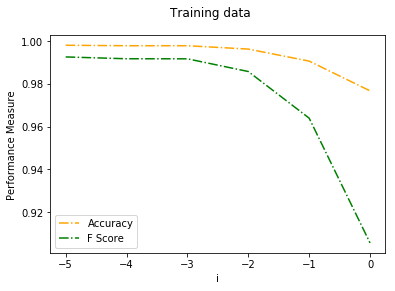

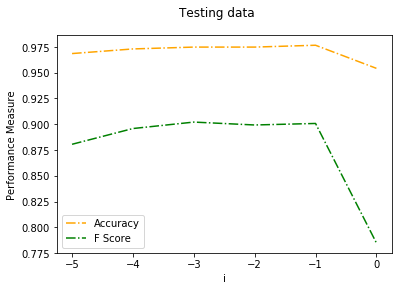

In [31]:
test_acc=[]
train_acc=[]
f1_score_train=[]
f1_score_test=[]
i_value=[]
for x in range(-5,1,1):
    i_value.append(x)
    var_alpha=pow(2,x)
    nb_1 = NaiveBayes().fit(X_train, y_train,alpha=var_alpha)
    y_predict_train=(nb_1.predict(X_train))
    y_predict=(nb_1.predict(X_test))

    confusion_matrix_train=calc_confusion_mat(y_train, y_predict_train)
    confusion_matrix_test=calc_confusion_mat(y_test, y_predict)
    train_acc.append( getAccuracy(y_train,y_predict_train))
    test_acc.append( getAccuracy(y_test,y_predict))
    label=1
    f1_score_train.append(f_score(precision(label,confusion_matrix_train),recall(label,confusion_matrix_train)))
    f1_score_test.append(f_score(precision(label,confusion_matrix_test),recall(label,confusion_matrix_test)))
func_graph(train_acc,i_value,f1_score_train,'Training data ')  
func_graph(test_acc,i_value,f1_score_test,'Testing data ') 
